In [ ]:
# %% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import tensorflow as tf
import warnings

warnings.simplefilter("ignore")

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load datasets
fertilizer_data = pd.read_csv('Fertilizer Prediction.csv')
crop_yield_data = pd.read_csv('crop_yield.csv')

In [4]:
# Standardize column names in fertilizer data for merging compatibility
fertilizer_data = fertilizer_data.rename(columns={
    'Temparature': 'Temperature',
    'Phosphorous': 'Phosphorus',
    'Crop Type': 'Crop'
})
fertilizer_data.columns = fertilizer_data.columns.str.strip()


In [5]:
# Merge fertilizer and crop yield data on 'Crop' and environmental factors
merged_data = pd.merge(crop_yield_data, fertilizer_data, on='Crop', how='inner')


In [6]:
# Display merged data to verify structure
print(merged_data.head())

    Crop  Crop_Year       Season  State     Area  Production  Annual_Rainfall  \
0  Maize       1997  Kharif       Assam  19216.0       14721           2051.4   
1  Maize       1997  Kharif       Assam  19216.0       14721           2051.4   
2  Maize       1997  Kharif       Assam  19216.0       14721           2051.4   
3  Maize       1997  Kharif       Assam  19216.0       14721           2051.4   
4  Maize       1997  Kharif       Assam  19216.0       14721           2051.4   

   Fertilizer  Pesticide     Yield  Temperature  Humidity  Moisture Soil Type  \
0  1828786.72    5956.96  0.615652           26        52        38     Sandy   
1  1828786.72    5956.96  0.615652           31        62        48     Sandy   
2  1828786.72    5956.96  0.615652           26        52        44     Sandy   
3  1828786.72    5956.96  0.615652           33        64        51     Sandy   
4  1828786.72    5956.96  0.615652           30        60        47     Sandy   

   Nitrogen  Potassium  Ph

## Data understanding

In [7]:
# Data Description
merged_data.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorus
count,23247.000000,2.324700e+04,2.324700e+04,23247.000000,2.324700e+04,2.324700e+04,23247.000000,23247.000000,23247.000000,23247.000000,23247.000000,23247.000000,23247.000000
mean,2008.691530,3.370768e+05,4.866061e+06,1459.972309,4.565129e+07,9.192978e+04,19.160136,30.621112,59.834344,45.658278,17.703876,4.471975,18.143804
std,6.506527,1.121198e+06,1.765792e+07,859.099741,1.564708e+08,3.220517e+05,33.367345,3.416541,5.772737,9.979583,10.826770,6.202217,11.946636
min,1997.000000,8.000000e-01,0.000000e+00,301.300000,1.207680e+02,1.700000e-01,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,2003.000000,1.874000e+03,8.270000e+03,907.800000,2.677480e+05,5.000000e+02,1.462778,28.000000,54.000000,38.000000,10.000000,0.000000,10.000000
50%,2009.000000,2.288300e+04,9.859200e+04,1253.600000,3.075659e+06,6.303000e+03,2.476500,30.000000,60.000000,48.000000,12.000000,0.000000,19.000000
75%,2014.000000,1.762000e+05,1.069228e+06,1735.400000,2.296277e+07,4.509057e+04,32.670000,34.000000,65.000000,53.000000,23.000000,9.000000,29.000000
max,2020.000000,1.021652e+07,1.796982e+08,6552.700000,1.754789e+09,3.780111e+06,989.870000,38.000000,72.000000,60.000000,41.000000,18.000000,42.000000


In [8]:
# Unique crops
merged_data.Crop.unique()


array(['Maize', 'Sugarcane', 'Tobacco', 'Wheat', 'Barley'], dtype=object)

In [9]:
# Data info
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23247 entries, 0 to 23246
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             23247 non-null  object 
 1   Crop_Year        23247 non-null  int64  
 2   Season           23247 non-null  object 
 3   State            23247 non-null  object 
 4   Area             23247 non-null  float64
 5   Production       23247 non-null  int64  
 6   Annual_Rainfall  23247 non-null  float64
 7   Fertilizer       23247 non-null  float64
 8   Pesticide        23247 non-null  float64
 9   Yield            23247 non-null  float64
 10  Temperature      23247 non-null  int64  
 11  Humidity         23247 non-null  int64  
 12  Moisture         23247 non-null  int64  
 13  Soil Type        23247 non-null  object 
 14  Nitrogen         23247 non-null  int64  
 15  Potassium        23247 non-null  int64  
 16  Phosphorus       23247 non-null  int64  
 17  Fertilizer N

In [11]:
# Checking for missing values
print(merged_data.isna().sum())


Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
Temperature        0
Humidity           0
Moisture           0
Soil Type          0
Nitrogen           0
Potassium          0
Phosphorus         0
Fertilizer Name    0
dtype: int64


In [12]:
# Check for duplicated rows in merged_data and count occurrences
print(merged_data.duplicated().value_counts())


False    23247
Name: count, dtype: int64


## Exploratory Data Analysis

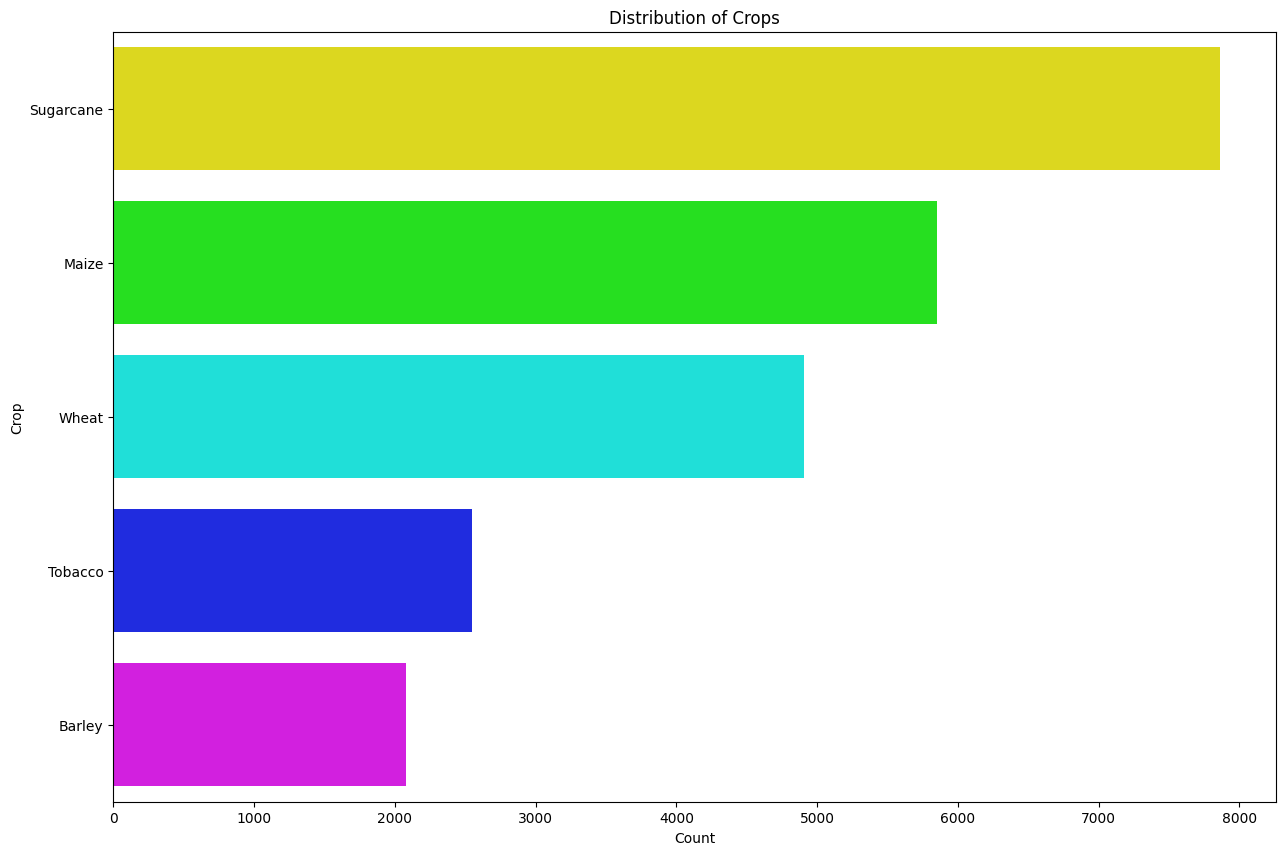

In [13]:
# Distribution of crops
plt.figure(figsize=(15, 10))
unique_crops = merged_data['Crop'].nunique()
palette = sns.color_palette("hsv", unique_crops)
sns.countplot(y=merged_data['Crop'], order=merged_data['Crop'].value_counts().index, palette=palette)
plt.title('Distribution of Crops')
plt.xlabel('Count')
plt.ylabel('Crop')
plt.show()


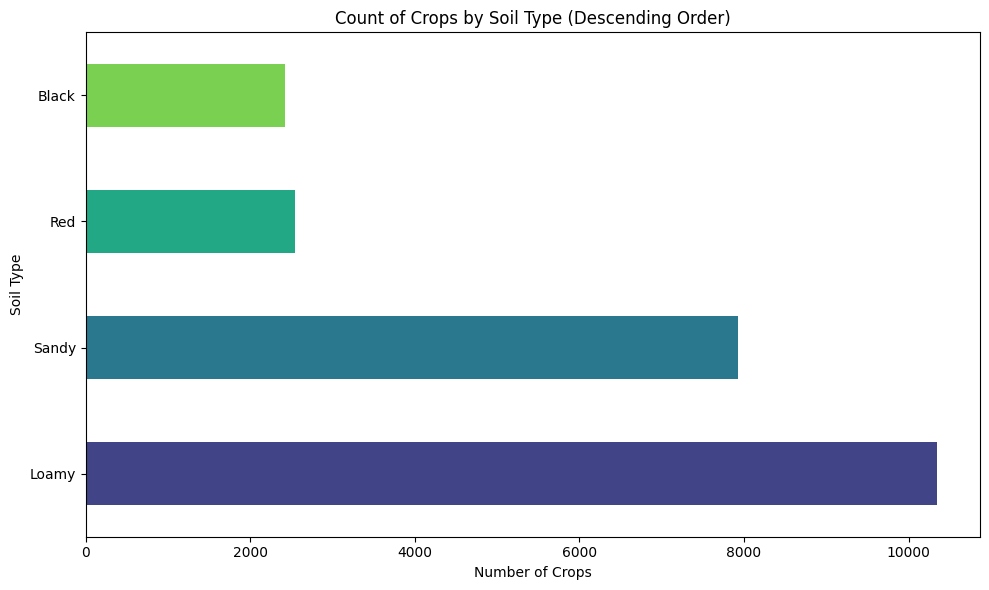

In [14]:
# Horizontal bar chart for count of crops by Soil Type
plt.figure(figsize=(10, 6))
unique_soil_types = merged_data['Soil Type'].nunique()
palette = sns.color_palette("viridis", unique_soil_types)
soil_type_counts = merged_data.groupby('Soil Type')['Crop'].count().sort_values(ascending=False)
soil_type_counts.plot(kind='barh', color=palette)
plt.title('Count of Crops by Soil Type (Descending Order)')
plt.xlabel('Number of Crops')
plt.ylabel('Soil Type')
plt.tight_layout()
plt.show()

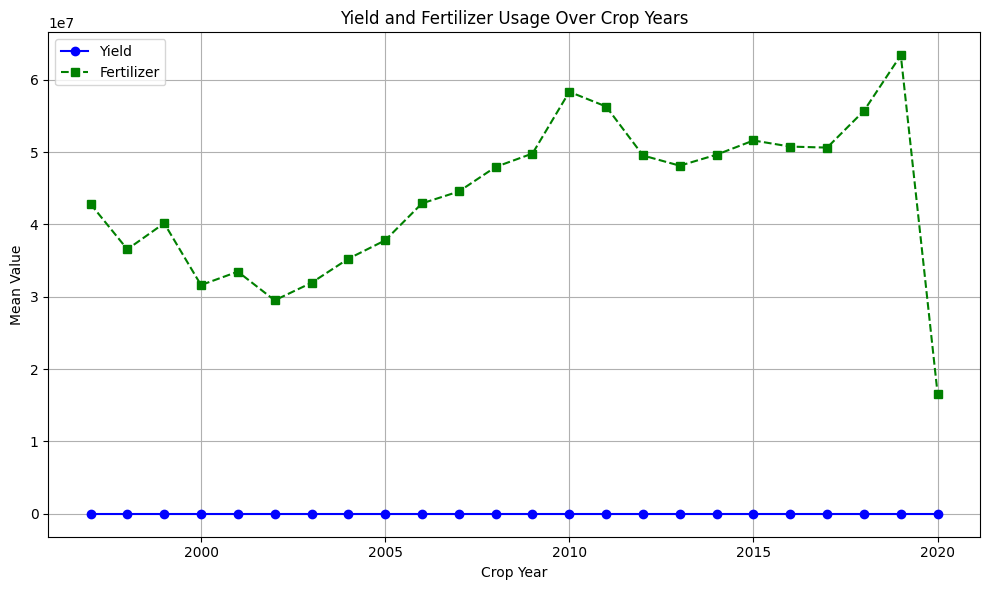

In [15]:
# Line graph for Yield over Crop Year with Fertilizer as an additional dimension
plt.figure(figsize=(10, 6))
yield_data = merged_data.groupby('Crop_Year').agg({'Yield': 'mean', 'Fertilizer': 'mean'}).reset_index()
plt.plot(yield_data['Crop_Year'], yield_data['Yield'], marker='o', label='Yield', color='b')
plt.plot(yield_data['Crop_Year'], yield_data['Fertilizer'], marker='s', label='Fertilizer', linestyle='--', color='g')
plt.title('Yield and Fertilizer Usage Over Crop Years')
plt.xlabel('Crop Year')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

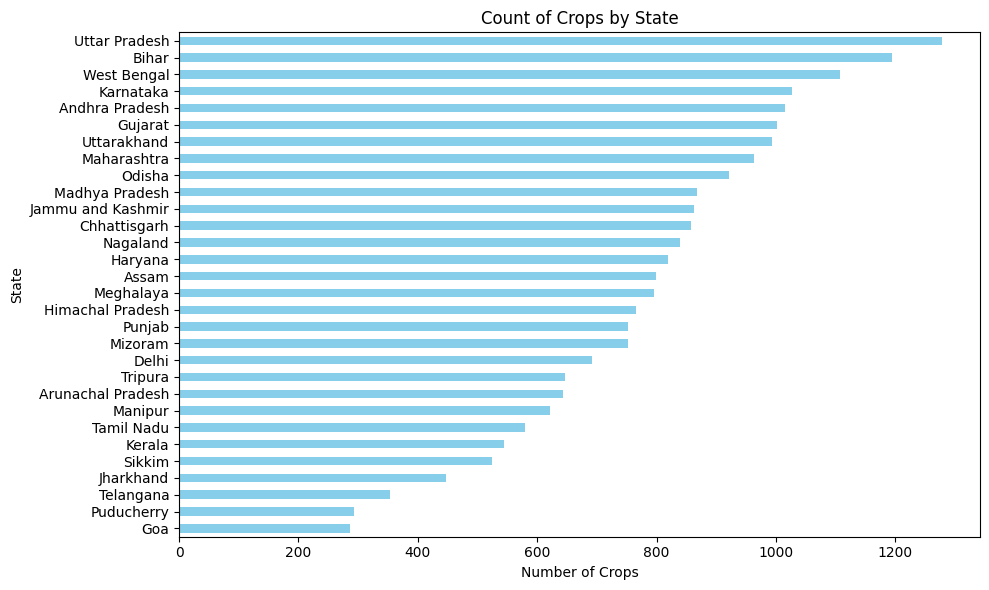

In [16]:
plt.figure(figsize=(10, 6))
merged_data.groupby('State')['Crop'].count().sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Count of Crops by State')
plt.xlabel('Number of Crops')
plt.ylabel('State')
plt.tight_layout()
plt.show()

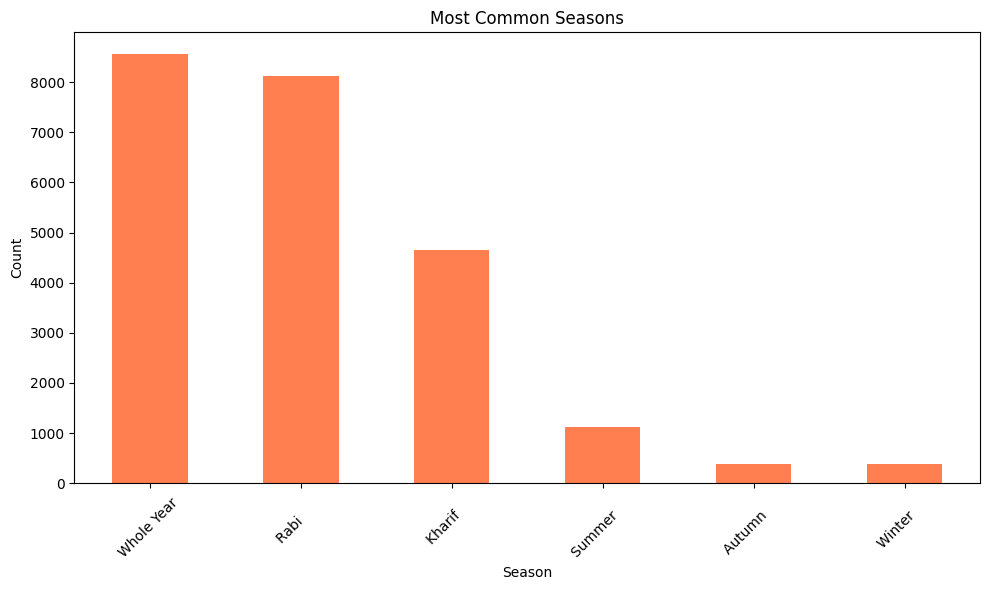

In [17]:
# Count of seasons across states
plt.figure(figsize=(10, 6))
merged_data['Season'].value_counts().plot(kind='bar', color='coral')
plt.title('Most Common Seasons')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

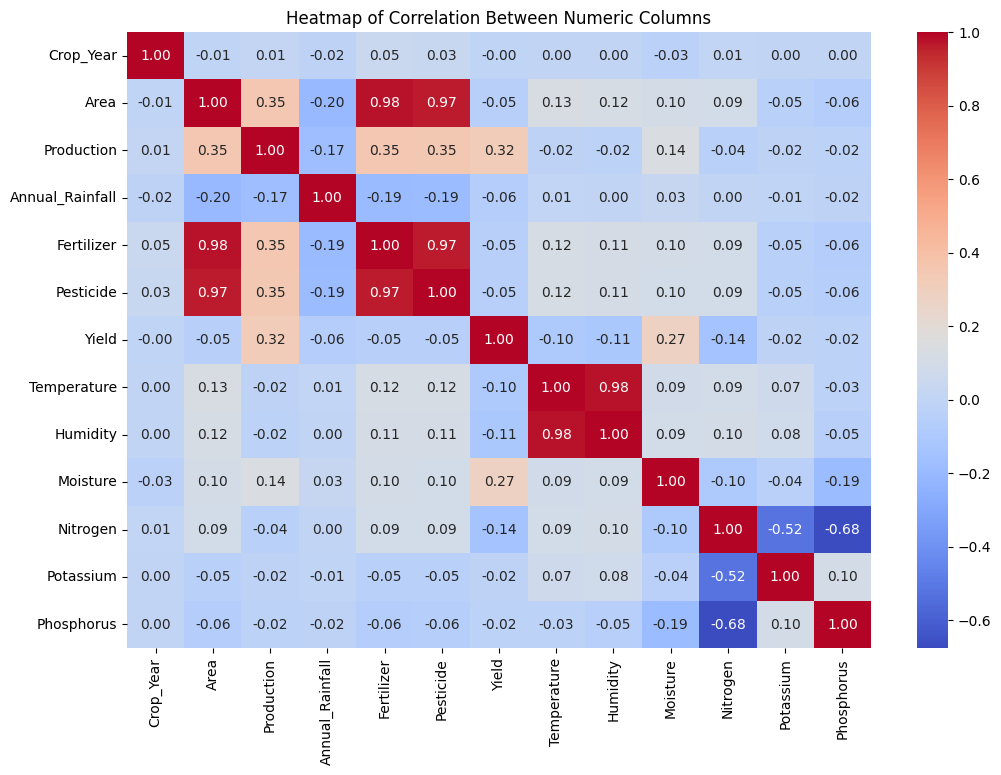

In [18]:
# Heatmap for correlation of numeric columns in merged_data
plt.figure(figsize=(12, 8))
sns.heatmap(merged_data.select_dtypes(include=[float, int]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Between Numeric Columns')
plt.show()

## Data Preprocessing

In [19]:
#Label Encoding
label_encoder = LabelEncoder()
merged_data['Season'] = label_encoder.fit_transform(merged_data['Season'])
merged_data['State'] = label_encoder.fit_transform(merged_data['State'])
merged_data['Crop'] = label_encoder.fit_transform(merged_data['Crop'])
merged_data['Soil Type'] = label_encoder.fit_transform(merged_data['Soil Type'])
merged_data['Fertilizer Name'] = label_encoder.fit_transform(merged_data['Fertilizer Name'])


In [20]:
# Feature scaling for numerical and encoded categorical features
scaler = StandardScaler()
scaled_features = [
    'Crop_Year', 'Area', 'Production', 'Annual_Rainfall', 'Fertilizer',
    'Pesticide', 'Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorus',
    'Season', 'State', 'Crop', 'Soil Type', 'Fertilizer Name'
]

for feature in scaled_features:
    merged_data[f'{feature}_scaled'] = scaler.fit_transform(merged_data[[feature]])


In [21]:
# Apply StandardScaler to create 'Yield_scaled'
merged_data['Yield_scaled'] = scaler.fit_transform(merged_data[['Yield']])


In [23]:
# Outlier Detection using IQR (Printing the number of outliers per feature)
for feature in scaled_features:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = merged_data[f'{feature}'].quantile(0.25)
    Q3 = merged_data[f'{feature}'].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = merged_data[(merged_data[f'{feature}'] < lower_bound) | (merged_data[f'{feature}'] > upper_bound)]


    # Print the number of outliers for the current feature
    print(f"Number of outliers for feature '{feature}': {len(outliers)}\n")


Number of outliers for feature 'Crop_Year': 0

Number of outliers for feature 'Area': 2666

Number of outliers for feature 'Production': 4185

Number of outliers for feature 'Annual_Rainfall': 1378

Number of outliers for feature 'Fertilizer': 2740

Number of outliers for feature 'Pesticide': 2856

Number of outliers for feature 'Temperature': 0

Number of outliers for feature 'Humidity': 0

Number of outliers for feature 'Moisture': 0

Number of outliers for feature 'Nitrogen': 0

Number of outliers for feature 'Potassium': 0

Number of outliers for feature 'Phosphorus': 0

Number of outliers for feature 'Season': 0

Number of outliers for feature 'State': 0

Number of outliers for feature 'Crop': 0

Number of outliers for feature 'Soil Type': 0

Number of outliers for feature 'Fertilizer Name': 0



In [ ]:
# Extract features (X) and target (y)
features = [f'{feature}_scaled' for feature in scaled_features]
target = 'Yield_scaled'

X = merged_data[features]
y = merged_data[target]

# Print the updated feature list
print(f"Features used for training: {features}")


Features used for training: ['Crop_Year_scaled', 'Area_scaled', 'Production_scaled', 'Annual_Rainfall_scaled', 'Fertilizer_scaled', 'Pesticide_scaled', 'Temperature_scaled', 'Humidity_scaled', 'Moisture_scaled', 'Nitrogen_scaled', 'Potassium_scaled', 'Phosphorus_scaled', 'Season_scaled', 'State_scaled', 'Crop_scaled', 'Soil Type_scaled', 'Fertilizer Name_scaled']


In [25]:
# Apply Recursive Feature Elimination (RFE)
# Instantiate RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Apply Recursive Feature Elimination (RFE)
num_features_to_select = 12 # Defining the number of features I want to select
rfe = RFE(estimator=rf_reg, n_features_to_select=num_features_to_select)
rfe.fit(X, y)

# Extract the selected features
selected_features = [feature for feature, selected in zip(features, rfe.support_) if selected]

print(f"Selected Features using RFE: {selected_features}")

Selected Features using RFE: ['Crop_Year_scaled', 'Area_scaled', 'Production_scaled', 'Annual_Rainfall_scaled', 'Fertilizer_scaled', 'Pesticide_scaled', 'Moisture_scaled', 'Season_scaled', 'State_scaled', 'Crop_scaled', 'Soil Type_scaled', 'Fertilizer Name_scaled']


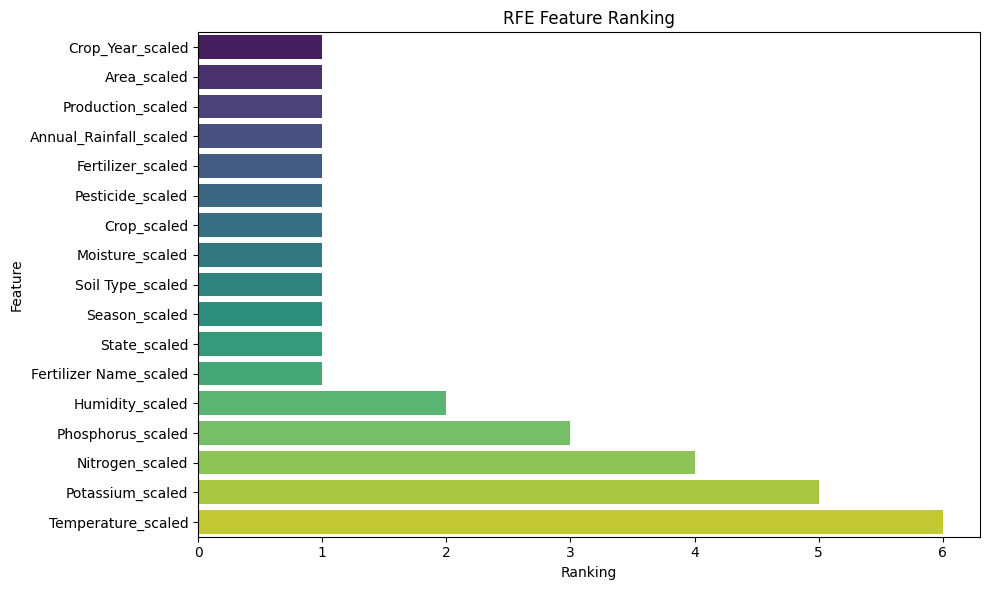

In [26]:
# Plot RFE ranking of features
rfe_ranking = pd.DataFrame({'Feature': features, 'Ranking': rfe.ranking_}).sort_values(by='Ranking')
plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=rfe_ranking, palette='viridis', order=rfe_ranking['Feature'])
plt.title('RFE Feature Ranking')
plt.tight_layout()
plt.show()

In [27]:
# Define the selected scaled features and targets to extract
X = merged_data[selected_features]
y = merged_data[['Yield_scaled', 'Fertilizer_scaled', 'Crop', 'Fertilizer Name']]


## DATA SPLITTING

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## TRAINING AND TESTING BASE MODELS


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       610
           1       1.00      1.00      1.00      1793
           2       1.00      1.00      1.00      2348
           3       1.00      1.00      1.00       764
           4       1.00      1.00      1.00      1460

    accuracy                           1.00      6975
   macro avg       1.00      1.00      1.00      6975
weighted avg       1.00      1.00      1.00      6975



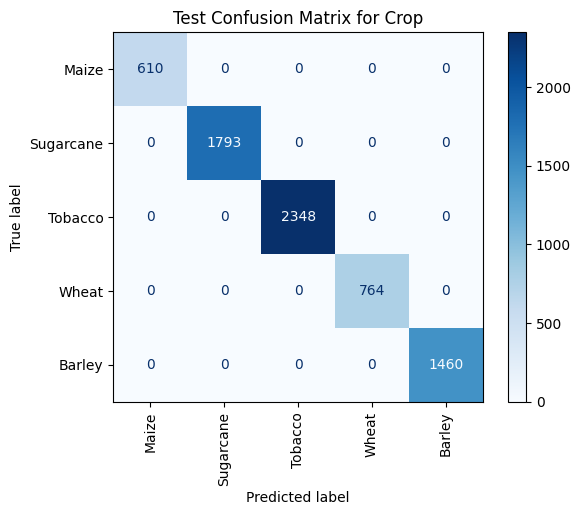

In [ ]:

# Random Forest for Crop Classification
rf_crop = RandomForestClassifier(random_state=42)
rf_crop.fit(X_train, y_train['Crop'])
rf_crop_features = rf_crop.predict_proba(X_train)

# Predict on test sets
y_test_pred_rf = rf_crop.predict(X_test) 

# Generate the classification report for the test set
test_classification_report = classification_report(y_test['Crop'], y_test_pred_rf)
print("\nTest Classification Report:\n", test_classification_report)

# Decode the predictions and true values back to the original labels
y_test_true = label_encoder.inverse_transform(y_test['Crop'])
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_rf)

# Generate the confusion matrix with actual labels
test_cf_matrix = confusion_matrix(y_test_true, y_test_pred_labels)

# Define the specific crop names for display
desired_labels = ['Maize', 'Sugarcane', 'Tobacco', 'Wheat', 'Barley']

# Display the confusion matrix with only the desired crop names
disp = ConfusionMatrixDisplay(confusion_matrix=test_cf_matrix, display_labels=desired_labels)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Test Confusion Matrix for Crop")
plt.show()


In [30]:
# Gradient Boosting for Yield Prediction
gb_yield = GradientBoostingRegressor(random_state=42)
gb_yield.fit(X_train, y_train['Yield_scaled'])
gb_yield_features = gb_yield.predict(X_train).reshape(-1, 1)



In [31]:
# LSTM for Fertilizer Prediction
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
lstm_input = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(50, activation='relu')(lstm_input)
lstm_output = Dense(1)(lstm_layer)
lstm_model = Model(inputs=lstm_input, outputs=lstm_output)
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_reshaped, y_train['Fertilizer_scaled'], epochs=10, batch_size=32, verbose=1)
lstm_features = lstm_model.predict(X_train_reshaped).reshape(-1, 1)

Epoch 1/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3101
Epoch 2/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0054
Epoch 3/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020
Epoch 4/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013
Epoch 5/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.0012e-04
Epoch 6/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8135e-04
Epoch 7/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7393e-04
Epoch 8/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9318e-04
Epoch 9/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6681e-04
Epoch 10/10
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6545e-04
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


## XGBOOST META-MODEL

In [32]:
# Combine features from base models
ensemble_features = np.hstack([rf_crop_features, gb_yield_features, lstm_features])


In [33]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid for GridSearchCV for XGBoost Regressor
param_grid_xgb = {
    'n_estimators': [100, 300, 500],  # Different numbers of trees
    'learning_rate': [0.01, 0.1],  # Learning rates to consider
    'max_depth': [3, 5, 7],  # Maximum depth of trees
    'subsample': [0.8, 1.0],  # Subsampling ratio
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of columns to use for each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term
    'reg_lambda': [1, 2]  # L2 regularization term
}

# Instantiate the XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to find the best hyperparameters for XGBoost Regressor
grid_search_xgb.fit(ensemble_features, y_train['Yield_scaled'][:ensemble_features.shape[0]])

# Display the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print(f"Best Hyperparameters for XGBoost Regressor: {best_params_xgb}")

# Use the best hyperparameters to fit the XGBoost Regressor meta-model
meta_model = XGBRegressor(
    n_estimators=best_params_xgb['n_estimators'],
    learning_rate=best_params_xgb['learning_rate'],
    max_depth=best_params_xgb['max_depth'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    reg_alpha=best_params_xgb['reg_alpha'],
    reg_lambda=best_params_xgb['reg_lambda'],
    objective='reg:squarederror',
    random_state=42
)

# Fit the optimized meta-model
meta_model.fit(ensemble_features, y_train['Yield_scaled'][:ensemble_features.shape[0]])


Fitting 2 folds for each of 648 candidates, totalling 1296 fits
Best Hyperparameters for XGBoost Regressor: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 1.0}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### NEURAL NETWORK FOR FINAL PREDICTIONS

In [34]:
ensemble_input = Input(shape=(ensemble_features.shape[1],))
combined_dense = Dense(64, activation='relu')(ensemble_input)
dropout = Dropout(0.3)(combined_dense)
final_output = Dense(3, name='final_output')(dropout)


In [35]:
# Define and compile the hybrid neural network model
hybrid_nn_model = Model(inputs=ensemble_input, outputs=final_output)
hybrid_nn_model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [36]:
# Train the Neural Network Meta-Model
hybrid_nn_model.fit(
    ensemble_features,
    y_train[['Yield_scaled', 'Fertilizer_scaled', 'Crop']],
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0023 - mse: 1.0023
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1082 - mse: 0.1082
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0885 - mse: 0.0885
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0758 - mse: 0.0758
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0742 - mse: 0.0742
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0684 - mse: 0.0684
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0642 - mse: 0.0642
Epoch 8/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0678 - mse: 0.0678
Epoch 9/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0587 - mse: 0.0587
Epoch 10/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0552 - mse: 0.0552
Epoch 11/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0562 - mse: 0.0562
Epoch 12/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0541 - mse: 0.0541
Epoch 13/50
509/509 ━━━━━

## EVALUATION OF THE HYBRID MODEL

In [37]:
# Predict with the hybrid model
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
rf_crop_test_features = rf_crop.predict_proba(X_test)
gb_yield_test_features = gb_yield.predict(X_test).reshape(-1, 1)
lstm_test_features = lstm_model.predict(X_test_reshaped).reshape(-1, 1)
ensemble_test_features = np.hstack([rf_crop_test_features, gb_yield_test_features, lstm_test_features])

final_predictions = hybrid_nn_model.predict(ensemble_test_features)

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [38]:
# Extract predictions for each target
yield_preds = final_predictions[:, 0]
fertilizer_preds = final_predictions[:, 1]
crop_preds = final_predictions[:, 2]

In [ ]:
# Crop Prediction Metrics
crop_actuals = y_test['Crop']
crop_pred_decoded = np.round(crop_preds).astype(int)
crop_accuracy = accuracy_score(crop_actuals, crop_pred_decoded)
crop_rmse = np.sqrt(mean_squared_error(crop_actuals, crop_pred_decoded))
crop_mae = mean_absolute_error(crop_actuals, crop_pred_decoded)
crop_mape = np.mean(np.abs((crop_actuals - crop_pred_decoded) / crop_actuals)) * 100 
crop_r2 = r2_score(crop_actuals, crop_pred_decoded)

print(f"Crop Classification Metrics:\n Accuracy: {crop_accuracy:.4f}\n RMSE: {crop_rmse:.4f}\n MAE: {crop_mae:.4f}\n MAPE: {crop_mape:.2f}%\n R^2: {crop_r2:.4f}")


Crop Classification Metrics:
 Accuracy: 0.9996
 RMSE: 0.0207
 MAE: 0.0004
 MAPE: 0.05%
 R^2: 0.9997


Classification Report for Crop Prediction:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       610
           1       1.00      1.00      1.00      1793
           2       1.00      1.00      1.00      2348
           3       1.00      1.00      1.00       764
           4       1.00      1.00      1.00      1460

    accuracy                           1.00      6975
   macro avg       1.00      1.00      1.00      6975
weighted avg       1.00      1.00      1.00      6975



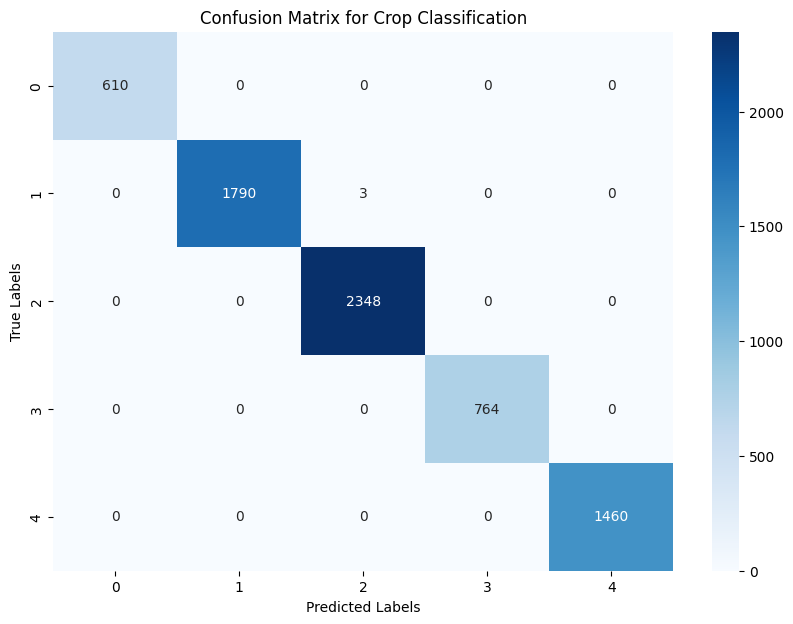

In [40]:
# Generate Classification Report and Confusion Matrix
print("Classification Report for Crop Prediction:\n")
print(classification_report(crop_actuals, crop_pred_decoded))

conf_matrix = confusion_matrix(crop_actuals, crop_pred_decoded)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(crop_actuals), yticklabels=np.unique(crop_actuals))
plt.title("Confusion Matrix for Crop Classification")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# Yield Metrics
yield_actuals = y_test['Yield_scaled']
yield_rmse = np.sqrt(mean_squared_error(yield_actuals, yield_preds))
yield_mae = mean_absolute_error(yield_actuals, yield_preds)
yield_mape = mean_absolute_percentage_error(yield_actuals, yield_preds) * 100 
yield_r2 = r2_score(yield_actuals, yield_preds)

print(f"Yield Prediction Metrics:\n RMSE: {yield_rmse:.4f}\n MAE: {yield_mae:.4f}\n MAPE: {yield_mape:.4f}%\n R^2: {yield_r2:.4f}")


Yield Prediction Metrics:
 RMSE: 0.1583
 MAE: 0.0914
 MAPE: 20.9480%
 R^2: 0.9782


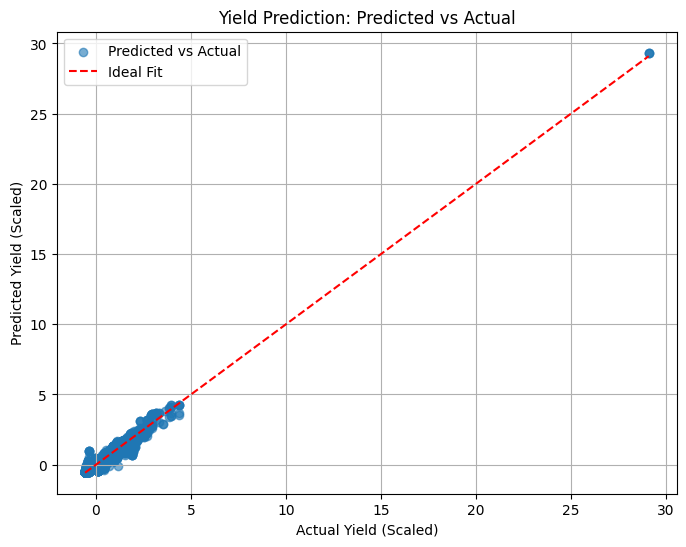

In [42]:
# Plot Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(yield_actuals, yield_preds, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(yield_actuals), max(yield_actuals)], [min(yield_actuals), max(yield_actuals)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("Actual Yield (Scaled)")
plt.ylabel("Predicted Yield (Scaled)")
plt.title("Yield Prediction: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Fertilizer Metrics
fertilizer_actuals = y_test['Fertilizer_scaled']
fertilizer_rmse = np.sqrt(mean_squared_error(fertilizer_actuals, fertilizer_preds))
fertilizer_mae = mean_absolute_error(fertilizer_actuals, fertilizer_preds)
fertilizer_mape = mean_absolute_percentage_error(fertilizer_actuals, fertilizer_preds) * 100  
fertilizer_r2 = r2_score(fertilizer_actuals, fertilizer_preds)

print(f"Fertilizer Prediction Metrics:\n RMSE: {fertilizer_rmse:.4f}\n MAE: {fertilizer_mae:.4f}\n MAPE: {fertilizer_mape:.2f}%\n R^2: {fertilizer_r2:.4f}")



Fertilizer Prediction Metrics:
 RMSE: 0.0322
 MAE: 0.0251
 MAPE: 18.70%
 R^2: 0.9988


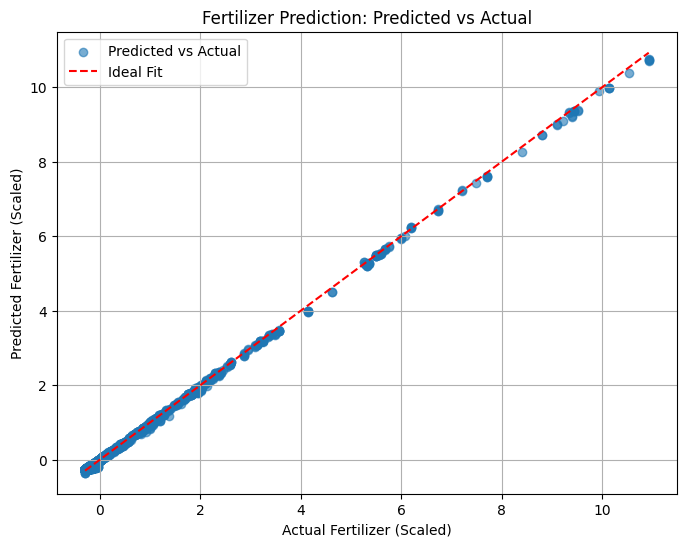

In [44]:
# Plot Predicted vs Actual values for Fertilizer
plt.figure(figsize=(8, 6))
plt.scatter(fertilizer_actuals, fertilizer_preds, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(fertilizer_actuals), max(fertilizer_actuals)], [min(fertilizer_actuals), max(fertilizer_actuals)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("Actual Fertilizer (Scaled)")
plt.ylabel("Predicted Fertilizer (Scaled)")
plt.title("Fertilizer Prediction: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()
